In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
import h3
import geopandas as gpd
import geojson

In [67]:
df = pd.read_csv("../data/analytics_trip_data.csv",nrows=2000000)

In [68]:
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])
df["trip_middle_timestamp"] = df["trip_start_timestamp"] + ((df['trip_end_timestamp']-df['trip_start_timestamp'])/2)
tempdf = df[(df["fare"] != 0) & (df["trip_miles"] != 0)]
df["price_per_mile"] = tempdf["fare"]/tempdf["trip_miles"]

In [69]:
pd.set_option('display.max_columns', None)
df.describe()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,temperature,precipitation,trip_middle_timestamp,price_per_mile
count,2000000,2000000,1.999901e+06,1.999926e+06,1.462124e+06,1.462124e+06,1.999207e+06,1.994371e+06,1.999906e+06,1.999906e+06,1.496914e+06,1.999906e+06,1.999906e+06,2.000000e+06,2.000000e+06,2000000,1.777854e+06
mean,2018-01-22 17:45:58.972950016,2018-01-22 17:58:14.362049536,7.231252e+02,3.086871e+00,1.703140e+10,1.703137e+10,2.457749e+01,2.201477e+01,1.210980e+01,1.562765e+00,1.724334e-03,7.204995e-01,1.451035e+01,-3.487046e+00,6.156000e-04,2018-01-22 17:52:06.667500800,8.068663e+00
min,2018-01-01 00:15:00,2018-01-01 00:15:00,0.000000e+00,0.000000e+00,1.703101e+10,1.703101e+10,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.277778e+01,0.000000e+00,2018-01-01 00:15:00,1.501502e-04
25%,2018-01-12 15:30:00,2018-01-12 15:30:00,3.000000e+02,6.500000e-01,1.703108e+10,1.703108e+10,8.000000e+00,8.000000e+00,5.750000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,-8.888889e+00,0.000000e+00,2018-01-12 15:30:00,3.676471e+00
50%,2018-01-22 22:00:00,2018-01-22 22:15:00,4.980000e+02,1.200000e+00,1.703128e+10,1.703128e+10,2.800000e+01,2.400000e+01,7.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.250000e+00,-4.444444e+00,0.000000e+00,2018-01-22 22:07:30,5.333333e+00
75%,2018-02-01 18:00:00,2018-02-01 18:15:00,8.400000e+02,2.800000e+00,1.703184e+10,1.703184e+10,3.200000e+01,3.200000e+01,1.200000e+01,2.000000e+00,0.000000e+00,1.000000e+00,1.406000e+01,1.666667e+00,0.000000e+00,2018-02-01 18:07:30,7.187500e+00
max,2018-02-12 14:45:00,2018-02-13 18:45:00,8.634000e+04,8.985000e+02,1.703198e+10,1.703198e+10,7.700000e+01,7.700000e+01,8.000900e+03,5.000000e+02,5.928000e+02,6.670660e+03,8.050970e+03,1.555556e+01,2.000000e-01,2018-02-12 22:15:00,6.001200e+04
std,NaN,NaN,1.237448e+03,4.920990e+00,3.418074e+05,3.321795e+05,1.911141e+01,1.719705e+01,2.716838e+01,2.658510e+00,5.455944e-01,1.158079e+01,3.065095e+01,7.838787e+00,1.032769e-02,NaN,7.208091e+01


## Choropleth

In [70]:
#Pass dataframe as pd object and h3geocol,datacol,legend_name as strings
def create_choropleth(dataframe,h3geocol,datacol,legend_name):
    grouped_data = dataframe.groupby(dataframe[h3geocol])[datacol].mean().reset_index()
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
    
    geojson_data = {
        'type': 'FeatureCollection',
        'features': []
    }
    
    for index, row in grouped_data.iterrows():
        geometry = {'type': 'Polygon', 'coordinates': [h3.h3_to_geo_boundary(row[h3geocol], geo_json=True)]}
        feature = {'type': 'Feature', 'geometry': geometry, 'properties': {f'{h3geocol}': row[h3geocol],f'{datacol}': row[datacol]}}
        geojson_data['features'].append(feature)
        
    cp = folium.Choropleth(
        geo_data=geojson_data,
        data=grouped_data,
        columns=[h3geocol, datacol],
        key_on=f'feature.properties.{h3geocol}',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)

    folium.GeoJsonTooltip([h3geocol,datacol]).add_to(cp.geojson)
    
    return m

In [71]:
create_choropleth(df,"h3_res_8_dropoff","trip_seconds","Average Total trip seconds")

In [72]:
create_choropleth(df,"h3_res_8_pickup","trip_total","Average total trip price")

In [73]:
create_choropleth(df,"h3_res_8_dropoff","tips","Average tips")

In [74]:
census_tract_geojson =  gpd.read_file("../data/Chicago_boundaries.geojson")

In [75]:
census_tract_geojson

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ..."
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ..."
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ..."
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ..."
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ..."
...,...,...,...,...,...,...,...,...,...,...
796,17,704,7,Census Tract 704,7,17031070400,,070400,031,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ..."
797,17,705,7,Census Tract 705,7,17031070500,,070500,031,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ..."
798,17,1303,13,Census Tract 1303,13,17031130300,,130300,031,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ..."
799,17,2922,29,Census Tract 2922,29,17031292200,,292200,031,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ..."


## Heatmap

In [76]:
tempdf = df.copy()

In [77]:
hourly = tempdf.groupby(df["trip_middle_timestamp"].dt.hour)["trip_seconds"].mean().reset_index()
weekdaily = tempdf.groupby(df["trip_middle_timestamp"].dt.weekday)["trip_seconds"].mean().reset_index()

In [78]:
# Neue Spalten für Stunde und Wochentag hinzufügen
tempdf['hour'] = df['trip_middle_timestamp'].dt.hour
tempdf['weekday'] = df['trip_middle_timestamp'].dt.day_name()

<Axes: xlabel='hour', ylabel='weekday'>

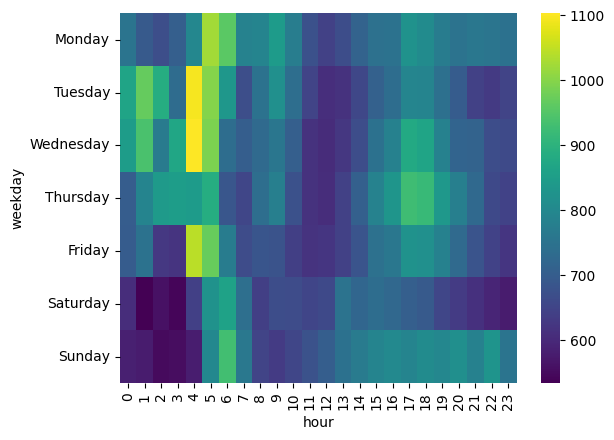

In [79]:
pivot_table_trip_seconds = tempdf.pivot_table(index='weekday', columns='hour', values='trip_seconds', aggfunc='mean')
pivot_table_trip_seconds = pivot_table_trip_seconds.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table_trip_seconds, cmap='viridis') #trip seconds

<Axes: xlabel='hour', ylabel='weekday'>

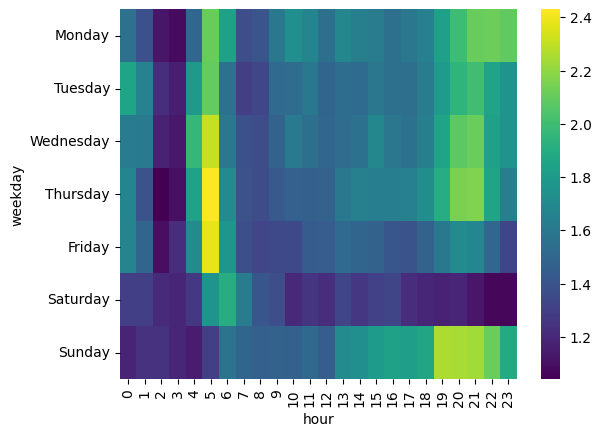

In [80]:
pivot_table_count = tempdf.pivot_table(index='weekday', columns='hour',values="tips",aggfunc='mean')
pivot_table_count = pivot_table_count.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table_count, cmap='viridis') #trip count

## Idle time

In [81]:
df_sorted = df.sort_values(by=['taxi_id', 'trip_start_timestamp'])
df_sorted['idle_time'] = df_sorted.groupby('taxi_id')['trip_start_timestamp'].shift(-1) - df_sorted['trip_end_timestamp']
idledf = df_sorted.groupby('taxi_id')['idle_time'].mean().reset_index()
idledf

,taxi_id,idle_time
0,0008de7a146802839c9e6059f482d292ebdae13c5c31dd...,0 days 02:02:28.660714285
1,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,0 days 01:26:02.779552715
2,0013da5489fe976daf4f4a7d246073ecf2caed9b12b3be...,0 days 01:44:35.815738963
3,0044e6c0d091476299b99345501f756b23632a96cbaf40...,0 days 02:53:59.413680781
4,00752524a4118a162dce62ff49c0eb0f79530d9e0ecb5a...,0 days 04:14:19.821428571
...,...,...
5223,ffd70d111c7da2e5eff27ad900c8eb94d74fe286bb7aa5...,0 days 02:47:21.543026706
5224,ffda53354c610fd3af1aee46d723028a49014e35f7280c...,0 days 01:46:40.568181818
5225,ffe8d8153b8f68cd20871ae5710f9b799bcc517b40ece7...,0 days 01:23:57.717908082
5226,fff3279af11dfade5e308184a5cc6c1ca2d33764634d96...,0 days 01:55:24.728850325


In [82]:
print(idledf.dtypes)

taxi_id               object
idle_time    timedelta64[ns]
dtype: object


<Axes: xlabel='idle_time', ylabel='Density'>

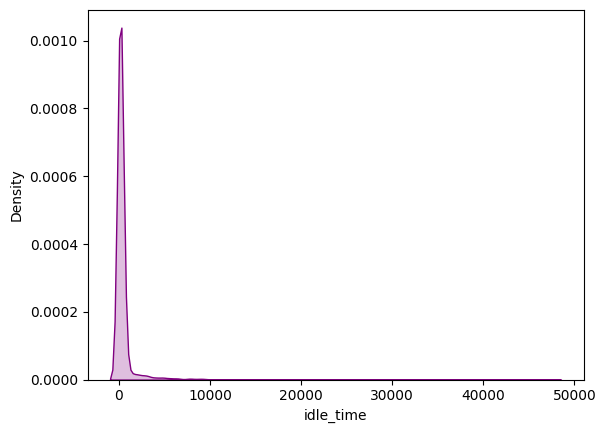

In [83]:
sns.kdeplot(idledf['idle_time'].dt.total_seconds() / 60, fill=True, color='purple')

## Correlation

In [84]:
corrdf = df.copy()

In [90]:
corrdf['date_hour'] = corrdf['trip_middle_timestamp'].dt.floor('h')
hourly_rides = corrdf.groupby('date_hour').size().reset_index(name='num_rides')
hourly_precipitation = corrdf.groupby('date_hour')['precipitation'].mean().reset_index()
hourly_temperature = corrdf.groupby('date_hour')['temperature'].mean().reset_index()
hourly_price_per_mile = corrdf.groupby('date_hour')['price_per_mile'].mean().reset_index()
# Merge the DataFrames
hourly_data = pd.merge(hourly_rides, hourly_precipitation, on='date_hour')
hourly_data = pd.merge(hourly_data, hourly_temperature, on='date_hour')
hourly_data = pd.merge(hourly_data, hourly_price_per_mile, on='date_hour')

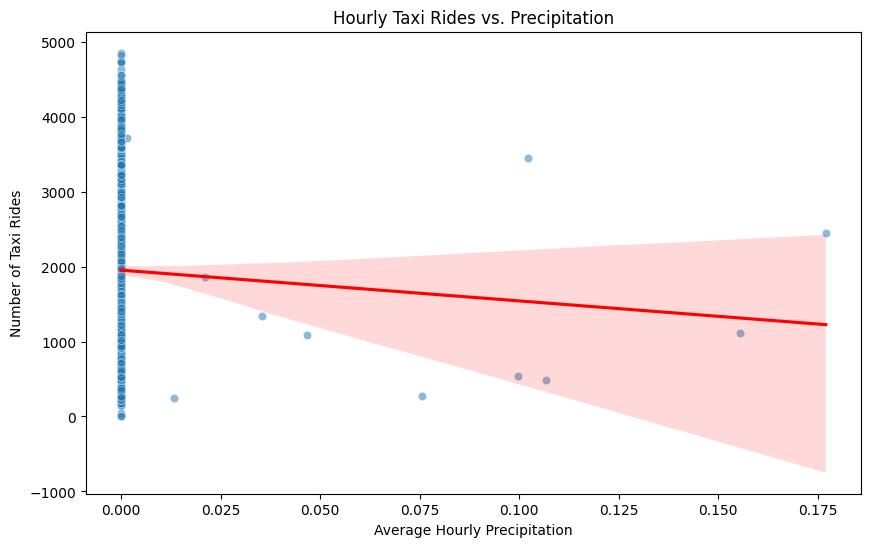

In [86]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='precipitation', y='num_rides', data=hourly_data, alpha=0.5)
sns.regplot(x='precipitation', y='num_rides', data=hourly_data, scatter=False, color='red')

plt.title('Hourly Taxi Rides vs. Precipitation')
plt.xlabel('Average Hourly Precipitation')
plt.ylabel('Number of Taxi Rides')
plt.show()

In [87]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Extract temperature and number of rides
X = hourly_data['temperature'].values.reshape(-1, 1)
y = hourly_data['num_rides'].values

# Create polynomial features
poly = PolynomialFeatures(degree=3)  
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict values
y_poly_pred = model.predict(X_poly)

# Add predictions to the DataFrame for plotting
hourly_data['num_rides_poly_pred'] = y_poly_pred

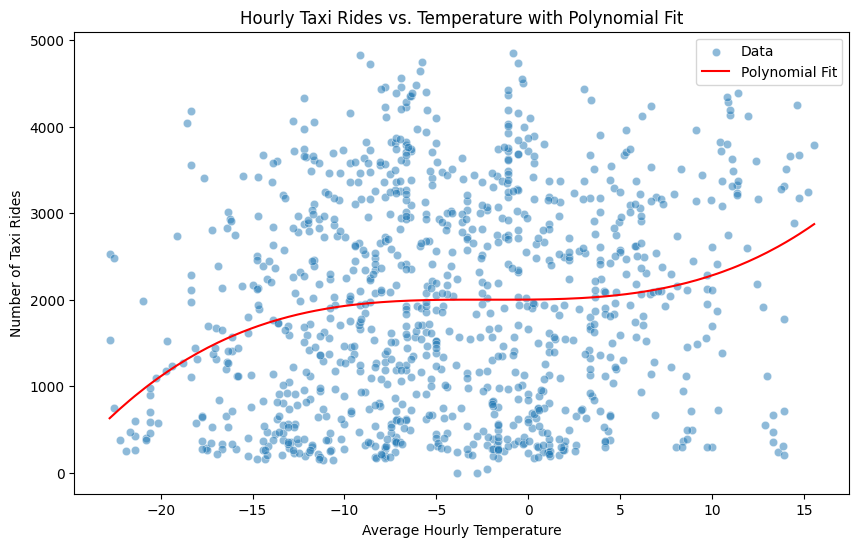

In [88]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='num_rides', data=hourly_data, alpha=0.5, label='Data')

# Sort the data for plotting the line
sorted_data = hourly_data.sort_values('temperature')
plt.plot(sorted_data['temperature'], sorted_data['num_rides_poly_pred'], color='red', label='Polynomial Fit')

plt.title('Hourly Taxi Rides vs. Temperature with Polynomial Fit')
plt.xlabel('Average Hourly Temperature')
plt.ylabel('Number of Taxi Rides')
plt.legend()
plt.show()

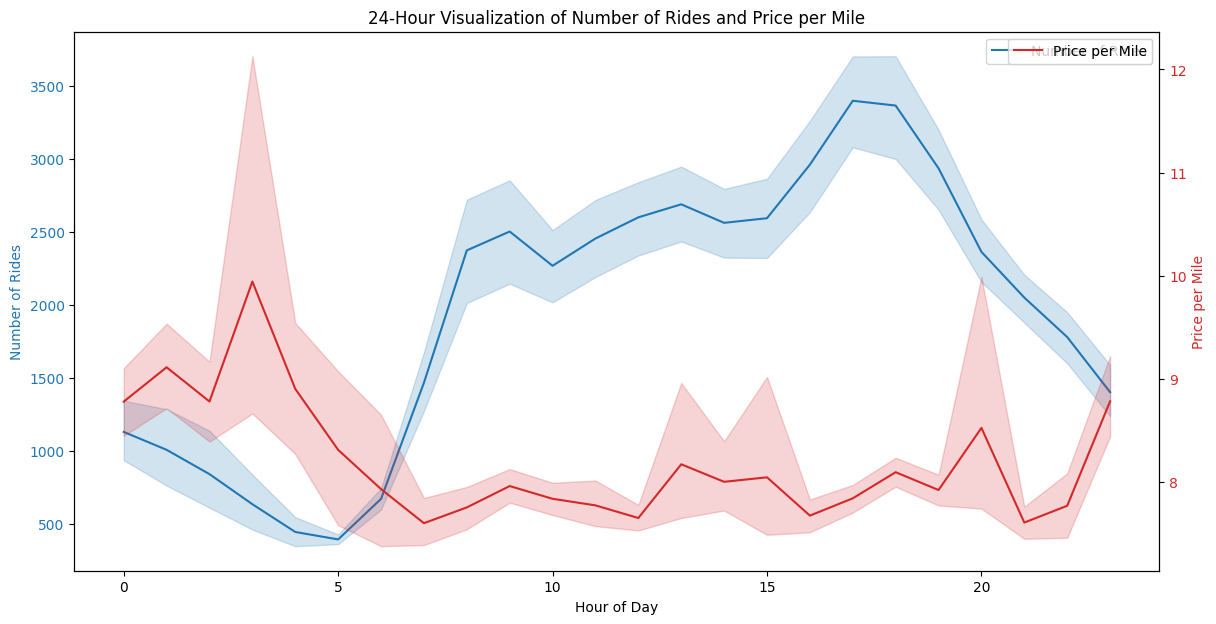

In [92]:
# Extract hour from date_hour
hourly_data['hour'] = hourly_data['date_hour'].dt.hour

# Create subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot number of rides
color = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Rides', color=color)
sns.lineplot(x='hour', y='num_rides', data=hourly_data, ax=ax1, color=color, label='Number of Rides')
ax1.tick_params(axis='y', labelcolor=color)

# Pplot price per mile
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Price per Mile', color=color)
sns.lineplot(x='hour', y='price_per_mile', data=hourly_data, ax=ax2, color=color, label='Price per Mile')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and show plot
plt.title('24-Hour Visualization of Number of Rides and Price per Mile')
plt.show()